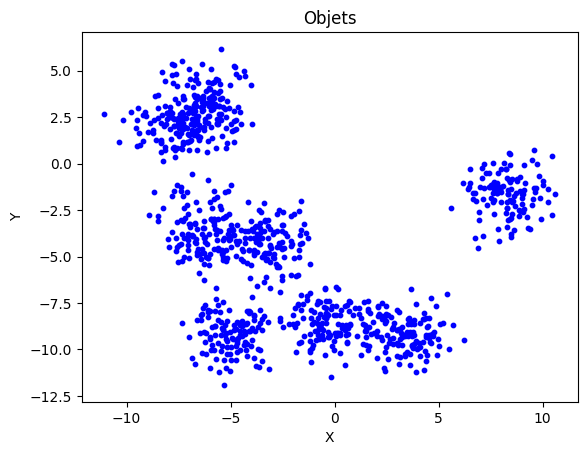

In [71]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

#
from minisom import MiniSom


# Générer des données pour k centres en utilisant make_blobs
k = 8
X, _ = make_blobs(n_samples=1000, centers=k, n_features=2,
                  shuffle=True, random_state=41)

# Créer un DataFrame à partir de X
data = pd.DataFrame(X, columns=['x', 'y'])

# Afficher les données avec Matplotlib
plt.scatter(X[:, 0], X[:, 1], c='blue', s=10)
plt.title('Objets')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [72]:
def initialiser_centroids(k, data):
    n_dims = data.shape[1]
    centroid_min, centroid_max = np.min(data, axis=0), np.max(data, axis=0)
    centroids = np.random.uniform(centroid_min, centroid_max, size=(k, n_dims))
    centroids = pd.DataFrame(centroids, columns=data.columns)
    return centroids


def calculer_distance(x1, x2):
    
    distance = np.sum(np.square(x1-x2))
    return distance


def assigner_centroid(data, centroids):  
    n_objets = data.shape[0]
    centroid_assign = []
    centroid_distances = []
    k = centroids.shape[0]
    centroids_arr = centroids.iloc[:, :2].to_numpy()

    for objet in range(n_objets):
        # Cauculer les distances avec les centroids
        distances = np.sum(
            np.square(centroids_arr - data.iloc[objet, :2].to_numpy()), axis=1)
        # Calculer le centroid le plus proche et ca distance
        centroid_plus_proche = np.argmin(distances)
        centroid_distance = np.min(distances)

        # Assigner les les meilleurs centroids aux objets
        centroid_assign.append(centroid_plus_proche)
        centroid_distances.append(centroid_distance)

    # retourner les deux listes l'assignation avec index, et les distances
    return (centroid_assign, centroid_distances)


def kmeans(data, k):
    # Initialiser les centroids et les distances
    centroids = initialiser_centroids(k, data)
    distance = []
    compr = True        # pour tester la boucle
    i = 0
    while (compr):
        # calculer les centroids et la distance , et l'assignation
        data['centroid'], iter_distance = assigner_centroid(data, centroids)
        #Ajouter la somme des distances renvoyé par assigner_centroid pour voir si les centroids sont fix ou pas
        distance.append(sum(iter_distance))
        # Recalculer les centres des clusters et MAJ leur nouveaux coordonnes
        centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)

        # Vérifier si on a changé ou pas
        if (len(distance) < 2):
            # Ici pour skiper la premiere iteratin car on ne peut pas comparer
            compr = True   
        else:
            if (round(distance[i], 3) != round(distance[i-1], 3)):
                compr = True
            else:
                # Cas de convergence
                compr = False
        i = i + 1
    data['centroid'], iter_distance = assigner_centroid(data, centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)
    return (data['centroid'], iter_distance, centroids)

def kmeans_elbow(data):

    # Initialiser les variables
    distances = []
    max_k = min(len(data), 10)
    # processus iteratif sur les valeurs de K
    for k in range(1, max_k + 1):
        
        data['centroid'], iter_distance, centroids = kmeans(data, k)
        distance = sum(iter_distance)

        # Sauvegarder les distances
        distances.append(distance)

    # Plot elbow curve
    plt.plot(range(1, max_k + 1), distances)
    plt.title('Elbow Curve')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Somme SCD intra cluster')
    plt.show()

    # Determiner le meilleur nombre de K
    elbow_index = np.argmin(np.diff(distances)) + 1
    meilleur_k = elbow_index + 1
    print("Meilleur K :", meilleur_k+1)

    # Perform K-means clustering with best k
    centroids = initialiser_centroids(meilleur_k, data)
    data['centroid'], iter_distance = assigner_centroid(data, centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)

    return (data['centroid'], iter_distance, centroids)



def som_cluster(data, k):
    # Normaliser les données
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

    # Créer une grille SOM avec k x k neurones
    som_grid = MiniSom(k, k, data.shape[1], sigma=1.0, learning_rate=0.5)

    # Initialiser les poids de la grille SOM avec des valeurs aléatoires
    som_grid.random_weights_init(data)

    # Entraîner le réseau SOM sur les données
    num_iterations = 100
    som_grid.train_random(data.to_numpy(), num_iterations*10)
    # Trouver les clusters pour chaque point de données
    clusters = []
    for i in range(data.shape[0]):
        x = data[i]
        cluster = som_grid.winner(x)
        clusters.append(cluster)

    # Retourner les clusters
    return clusters





0      5
1      1
2      5
3      5
4      6
      ..
995    5
996    6
997    4
998    5
999    4
Name: centroid, Length: 1000, dtype: int64


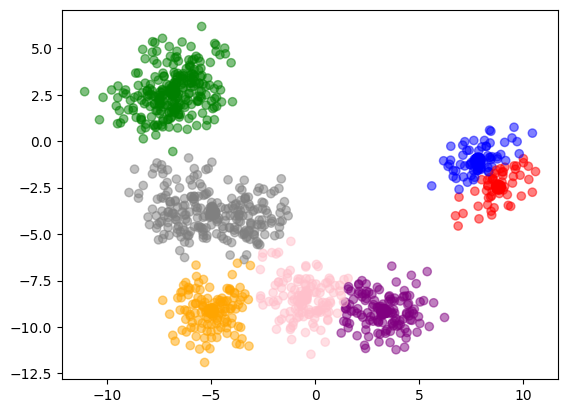

In [73]:
#Executer Kmeans

data_centroids, _, centroids = kmeans(data, k)
# data_centroids, _, centroids = knn_elbow(data)
print(data_centroids)
colors = {0: 'red', 1: 'blue', 2: 'green',
          3: 'purple', 4: 'orange', 5: 'gray', 6: 'pink'}
plt.scatter(data.iloc[:, 0], data.iloc[:, 1],  marker='o',
            c=data['centroid'].apply(lambda x: colors[x]), alpha=0.5)
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1],  marker='o', s=100,
            c=centroids.index.map(lambda x: colors[x]))

# Let's the elbow move move by shape of the net twenty types 


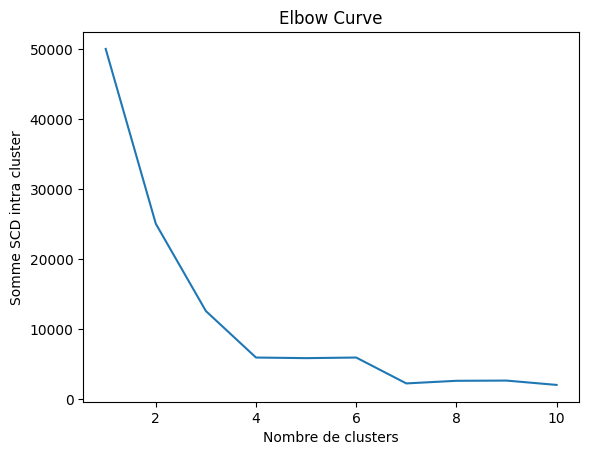

Meilleur K : 3


(0      0
 1      0
 2      0
 3      0
 4      0
       ..
 995    0
 996    0
 997    0
 998    0
 999    0
 Name: centroid, Length: 1000, dtype: int64,
 [0.4581405102513661,
  252.43615810922068,
  0.7879146762443938,
  0.5333115184745386,
  75.8044134014441,
  49.35227860879515,
  32.87473863710444,
  54.02526692651742,
  4.406518423765253,
  53.297571097712904,
  66.15350877134014,
  25.262246977497977,
  53.349878757640795,
  1.2354260766445357,
  29.825038176922828,
  24.172428505926163,
  97.7050788316763,
  204.73548767933033,
  69.67688712456652,
  129.87218219028202,
  2.839070211329498,
  19.95319443368931,
  24.63583203904956,
  113.8554210397214,
  16.98830421331694,
  18.968039167520022,
  110.17602995260845,
  42.2044000911471,
  293.21913352589166,
  52.9116706329128,
  21.04919987564084,
  11.192613307968788,
  10.963908393657348,
  20.48619588171205,
  0.2650826611843387,
  213.47217712258154,
  31.994659653036138,
  77.33198093201185,
  46.702077474669316,
  145.944

In [74]:
#Executer K means elbow
kmeans_elbow(data)

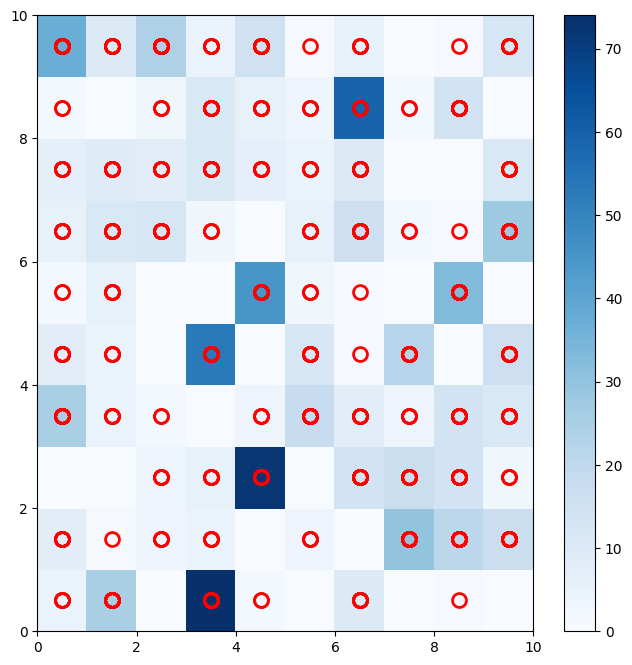

In [75]:

# Définir les dimensions de la carte SOM
som_width = 10
som_height = 10
input_len = 2

# Initialiser la carte SOM avec les dimensions précédentes
som = MiniSom(som_width, som_height, input_len, sigma=1.0, learning_rate=0.5)

# Initialiser les poids avec les valeurs aléatoires
som.random_weights_init(X)

# Entraîner la carte SOM sur les données
som.train_random(data=X, num_iteration=100)

# Trouver les gagnants pour chaque échantillon de données
winners = np.zeros((som_width, som_height))
for i in range(len(X)):
    x = X[i]
    winner = som.winner(x)
    winners[winner] += 1

# Visualiser la carte SOM et les données d'entrée
plt.figure(figsize=(8, 8))
plt.pcolor(winners.T, cmap='Blues')
plt.colorbar()

# Ajouter les marqueurs de données sur la carte SOM
for i, x in enumerate(X):
    winner = som.winner(x)
    plt.plot(winner[0] + 0.5, winner[1] + 0.5, 'o', markerfacecolor='None', markeredgecolor='r', markersize=10, markeredgewidth=2)

plt.show()
